In [1]:
!pip -q install -U transformers datasets accelerate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 45.0 MB/s eta 0:00:00


In [2]:
# ============================================================================
# PART 0: UPLOAD AND EXTRACT LOCAL DATA
# ============================================================================

from google.colab import files
import zipfile
import os

print("Please upload dev_phase.zip:")
uploaded = files.upload()

print("\nUploaded files:")
for filename in uploaded.keys():
    print(f"  {filename} ({len(uploaded[filename])} bytes)")

print("\nExtracting...")
with zipfile.ZipFile('dev_phase.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

print("✓ Extracted!")

print("\n📁 Directory structure:")
for root, dirs, files_ in os.walk('./data'):
    level = root.replace('./data', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files_[:5]:
        print(f'{subindent}{file}')
    if len(files_) > 5:
        print(f'{subindent}... and {len(files_)-5} more files')

print("\n✓ Data ready!")


Please upload dev_phase.zip:


Saving dev_phase.zip to dev_phase.zip

Uploaded files:
  dev_phase.zip (10040812 bytes)

Extracting...
✓ Extracted!

📁 Directory structure:
data/
  subtask1/
    dev/
      hau.csv
      spa.csv
      deu.csv
      hin.csv
      fas.csv
      ... and 8 more files
    train/
      hau.csv
      spa.csv
      deu.csv
      hin.csv
      fas.csv
      ... and 8 more files
  subtask2/
    dev/
      hau.csv
      spa.csv
      deu.csv
      hin.csv
      fas.csv
      ... and 8 more files
    train/
      hau.csv
      spa.csv
      deu.csv
      hin.csv
      fas.csv
      ... and 8 more files
  subtask3/
    dev/
      hau.csv
      spa.csv
      deu.csv
      hin.csv
      fas.csv
      ... and 7 more files
    train/
      hau.csv
      spa.csv
      deu.csv
      hin.csv
      fas.csv
      ... and 7 more files

✓ Data ready!


In [3]:
import os
import re
import random
import shutil
import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from datasets import Dataset, DatasetDict

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)


DEVICE: cuda


In [4]:
SUBTASK = "subtask1"
DATA_ROOT = "./data"

train_dir = os.path.join(DATA_ROOT, SUBTASK, "train")
dev_dir   = os.path.join(DATA_ROOT, SUBTASK, "dev")

assert os.path.isdir(train_dir), f"Missing: {train_dir}"
assert os.path.isdir(dev_dir),   f"Missing: {dev_dir}"

def list_lang_files(folder):
    files = [f for f in os.listdir(folder) if f.endswith(".csv")]
    files = sorted(files)
    langs = [os.path.splitext(f)[0] for f in files]
    return langs, files

langs_train, _ = list_lang_files(train_dir)
langs_dev, _   = list_lang_files(dev_dir)
assert langs_train == langs_dev, "Train/dev languages mismatch!"

LANGS = langs_train
print("Languages:", LANGS)

def read_csv(path):
    for enc in ["utf-8", "utf-8-sig", "latin1"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(path)

train_dfs, dev_dfs = {}, {}

for lang in LANGS:
    tr_path = os.path.join(train_dir, f"{lang}.csv")
    dv_path = os.path.join(dev_dir,   f"{lang}.csv")

    tr = read_csv(tr_path)
    dv = read_csv(dv_path)

    required_cols = {"id", "text", "polarization"}
    assert required_cols.issubset(tr.columns), f"Bad columns in {lang} train: {tr.columns}"
    assert required_cols.issubset(dv.columns), f"Bad columns in {lang} dev: {dv.columns}"

    train_dfs[lang] = tr
    dev_dfs[lang]   = dv

print("\nTrain sample (eng):")
print(train_dfs["eng"].head(2))

print("\nDev polarization NaN ratio (eng):", dev_dfs["eng"]["polarization"].isna().mean())


Languages: ['amh', 'arb', 'deu', 'eng', 'fas', 'hau', 'hin', 'ita', 'nep', 'spa', 'tur', 'urd', 'zho']

Train sample (eng):
                                     id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   

                                                text  polarization  
0           is defending imperialism in the dnd chat             0  
1  Still playing with this. I am now following Ra...             0  

Dev polarization NaN ratio (eng): 1.0


In [5]:
# ============================================================================
# SAFE CLEANING (Multilingual-friendly, meaning-preserving)
# - normalize whitespace
# - mask URLs / mentions / hashtags
# - cap extreme punctuation repeats
# ============================================================================
URL_RE = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
USER_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#\w+")
WS_RE = re.compile(r"\s+")

def clean_text(t: str) -> str:
    t = str(t)
    t = WS_RE.sub(" ", t).strip()
    t = URL_RE.sub("<URL>", t)
    t = USER_RE.sub("<USER>", t)
    t = HASHTAG_RE.sub("<HASHTAG>", t)
    t = re.sub(r"([!?.])\1{3,}", r"\1\1\1", t)  # "!!!!!" -> "!!!"
    t = WS_RE.sub(" ", t).strip()
    return t

for lang in LANGS:
    train_dfs[lang]["text"] = train_dfs[lang]["text"].astype(str).map(clean_text)
    dev_dfs[lang]["text"]   = dev_dfs[lang]["text"].astype(str).map(clean_text)

print("✓ Cleaning applied.")
print(train_dfs["eng"][["id", "text"]].head(2))


✓ Cleaning applied.
                                     id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   

                                                text  
0           is defending imperialism in the dnd chat  
1  Still playing with this. I am now following Ra...  


In [6]:
VAL_RATIO = 0.15
splits = {}

for lang in LANGS:
    df = train_dfs[lang].copy()
    df["polarization"] = df["polarization"].astype(int)

    tr, va = train_test_split(
        df,
        test_size=VAL_RATIO,
        random_state=SEED,
        stratify=df["polarization"]
    )

    splits[lang] = {
        "train": tr.reset_index(drop=True),
        "val":   va.reset_index(drop=True)
    }

print("ENG train/val sizes:", splits["eng"]["train"].shape, splits["eng"]["val"].shape)
print("ENG train label dist:\n", splits["eng"]["train"]["polarization"].value_counts())
print("ENG val   label dist:\n", splits["eng"]["val"]["polarization"].value_counts())


ENG train/val sizes: (2274, 3) (402, 3)
ENG train label dist:
 polarization
0    1423
1     851
Name: count, dtype: int64
ENG val   label dist:
 polarization
0    251
1    151
Name: count, dtype: int64


In [7]:
USE_LANG_PREFIX = True

def add_prefix(lang, text):
    return f"[{lang}] {text}" if USE_LANG_PREFIX else text

def make_joint_df(split_name):
    frames = []
    for lang in LANGS:
        df = splits[lang][split_name].copy()
        df["lang"] = lang
        df["text"] = df["text"].astype(str).map(lambda t: add_prefix(lang, t))
        frames.append(df[["id", "lang", "text", "polarization"]])
    return pd.concat(frames, ignore_index=True)

joint_train_df = make_joint_df("train")
joint_val_df   = make_joint_df("val")

dataset_joint = DatasetDict({
    "train": Dataset.from_pandas(joint_train_df),
    "validation": Dataset.from_pandas(joint_val_df),
})

print("Joint train:", joint_train_df.shape, "| Joint val:", joint_val_df.shape)
dataset_joint


Joint train: (34331, 4) | Joint val: (6064, 4)


DatasetDict({
    train: Dataset({
        features: ['id', 'lang', 'text', 'polarization'],
        num_rows: 34331
    })
    validation: Dataset({
        features: ['id', 'lang', 'text', 'polarization'],
        num_rows: 6064
    })
})

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# IMPORTANT: banned models are NOT included here.
MODEL_REGISTRY = {
    "distilmbert": "distilbert-base-multilingual-cased",
    "mbert": "bert-base-multilingual-cased",
    "minilm": "microsoft/Multilingual-MiniLM-L12-H384",
    # optional diversity model (older family). If it fails, it will be skipped.
    "xlm": "xlm-mlm-100-1280",
}

def safe_load_model_and_tokenizer(model_name, num_labels=2):
    try:
        tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        mdl = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        return tok, mdl
    except Exception as e:
        print(f"❌ SKIP model '{model_name}' due to load error:\n   {repr(e)}")
        return None, None

print(MODEL_REGISTRY)


{'distilmbert': 'distilbert-base-multilingual-cased', 'mbert': 'bert-base-multilingual-cased', 'minilm': 'microsoft/Multilingual-MiniLM-L12-H384', 'xlm': 'xlm-mlm-100-1280'}


In [9]:
MAX_LEN = 256

def tokenize_function(examples, tokenizer):
    return tokenizer(examples["text"], truncation=True, max_length=MAX_LEN)


In [10]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
import inspect

def compute_metrics_fn(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_pos": f1_score(labels, preds, pos_label=1),
    }

class WeightedOrFocalTrainer(Trainer):
    """
    - kwargs-safe compute_loss (handles extra args like num_items_in_batch)
    - supports class-weighted CE and focal loss
    """
    def __init__(self, *args, class_weights=None, use_focal=False, focal_gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.use_focal = use_focal
        self.focal_gamma = focal_gamma

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits

        # per-example CE (so focal works correctly)
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=(self.class_weights.to(logits.device) if self.class_weights is not None else None),
            reduction="none"
        )
        ce = loss_fct(logits, labels)  # [batch]

        if not self.use_focal:
            loss = ce.mean()
        else:
            probs = torch.softmax(logits, dim=-1)
            pt = probs.gather(1, labels.unsqueeze(1)).squeeze(1).clamp_min(1e-8)  # [batch]
            focal_weight = (1.0 - pt) ** self.focal_gamma
            loss = (focal_weight * ce).mean()

        return (loss, outputs) if return_outputs else loss

def build_training_args(output_dir, lr=2e-5, epochs=3, batch_size=16):
    sig = inspect.signature(TrainingArguments)
    kwargs = dict(
        output_dir=output_dir,
        learning_rate=lr,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        seed=SEED,
        fp16=torch.cuda.is_available(),
        report_to="none",
        logging_steps=50,
    )

    if "evaluation_strategy" in sig.parameters:
        kwargs["evaluation_strategy"] = "epoch"
        kwargs["save_strategy"] = "epoch"
        kwargs["logging_strategy"] = "steps"
    else:
        kwargs["eval_strategy"] = "epoch"
        kwargs["save_strategy"] = "epoch"
        kwargs["logging_strategy"] = "steps"

    return TrainingArguments(**kwargs)

def compute_class_weights_from_labels(labels_np):
    counts = np.bincount(labels_np, minlength=2)
    total = counts.sum()
    weights = total / (2.0 * np.clip(counts, 1, None))
    return torch.tensor(weights, dtype=torch.float), {0:int(counts[0]), 1:int(counts[1])}


In [11]:
def train_one_multilingual(model_key, use_weighted_loss=True, use_focal=False, focal_gamma=2.0,
                           lr=2e-5, epochs=3, batch_size=16):

    model_name = MODEL_REGISTRY[model_key]
    print(f"\n==============================")
    print(f"JOINT TRAIN: {model_key} -> {model_name}")
    print(f"weighted={use_weighted_loss} focal={use_focal} gamma={focal_gamma}")
    print(f"==============================")

    tokenizer, model = safe_load_model_and_tokenizer(model_name, num_labels=2)
    if tokenizer is None:
        return None, None

    tokenized = dataset_joint.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    tokenized = tokenized.rename_column("polarization", "labels")
    tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    class_weights = None
    if use_weighted_loss:
        y = joint_train_df["polarization"].astype(int).to_numpy()
        class_weights, dist = compute_class_weights_from_labels(y)
        print("Joint label dist:", dist, "| weights:", class_weights.tolist())

    args = build_training_args(
        output_dir=f"./runs_subtask1/joint_{model_key}",
        lr=lr, epochs=epochs, batch_size=batch_size
    )

    trainer = WeightedOrFocalTrainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_fn,
        class_weights=class_weights,
        use_focal=use_focal,
        focal_gamma=focal_gamma
    )

    trainer.train()
    metrics = trainer.evaluate()
    return trainer, metrics


In [12]:
# Control runtime here:
JOINT_MODELS_TO_RUN = ["distilmbert", "mbert", "minilm"]  # add "xlm" if you want (heavy)
JOINT_EPOCHS = 3
JOINT_LR = 2e-5
JOINT_BATCH = 16

joint_results = []
joint_trainers = {}

for mk in JOINT_MODELS_TO_RUN:
    tr, mt = train_one_multilingual(
        mk,
        use_weighted_loss=True,
        use_focal=False,
        lr=JOINT_LR,
        epochs=JOINT_EPOCHS,
        batch_size=JOINT_BATCH
    )
    if tr is None:
        continue
    joint_trainers[mk] = tr
    joint_results.append({"model_key": mk, "model_name": MODEL_REGISTRY[mk], **mt})

results_df = pd.DataFrame(joint_results).sort_values("eval_f1_macro", ascending=False)
print("=== Joint results ===")
display(results_df)

best_key = results_df.iloc[0]["model_key"]
best_trainer = joint_trainers[best_key]
print("Best joint model:", best_key)



JOINT TRAIN: distilmbert -> distilbert-base-multilingual-cased
weighted=True focal=False gamma=2.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34331 [00:00<?, ? examples/s]

Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

Joint label dist: {0: 16476, 1: 17855} | weights: [1.0418487787246704, 0.9613833427429199]


/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.459500,0.474832,0.766656,0.765933,0.778941
2,0.375300,0.497657,0.774077,0.773339,0.786271
3,0.298200,0.551495,0.776385,0.775745,0.787727



JOINT TRAIN: mbert -> bert-base-multilingual-cased
weighted=True focal=False gamma=2.0


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34331 [00:00<?, ? examples/s]

Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

Joint label dist: {0: 16476, 1: 17855} | weights: [1.0418487787246704, 0.9613833427429199]


/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.469800,0.504636,0.763028,0.762965,0.766834
2,0.387400,0.505362,0.783476,0.783270,0.789954
3,0.274100,0.594856,0.783146,0.782693,0.792619



JOINT TRAIN: minilm -> microsoft/Multilingual-MiniLM-L12-H384
weighted=True focal=False gamma=2.0


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34331 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 0, 'pad_token_id': 1}.


Joint label dist: {0: 16476, 1: 17855} | weights: [1.0418487787246704, 0.9613833427429199]


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.461500,0.486830,0.764677,0.764660,0.762681
2,0.427200,0.454966,0.782982,0.782973,0.784333
3,0.361700,0.476521,0.789413,0.789253,0.795057


=== Joint results ===


,model_key,model_name,eval_loss,eval_accuracy,eval_f1_macro,eval_f1_pos,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
2,minilm,microsoft/Multilingual-MiniLM-L12-H384,0.476521,0.789413,0.789253,0.795057,6.4336,942.554,58.910,3.0
1,mbert,bert-base-multilingual-cased,0.505362,0.783476,0.783270,0.789954,6.3470,955.407,59.713,3.0
0,distilmbert,distilbert-base-multilingual-cased,0.551495,0.776385,0.775745,0.787727,3.9327,1541.950,96.372,3.0


Best joint model: minilm


In [13]:
RUN_FOCAL = True  # set True if you want

focal_df = None
if RUN_FOCAL:
    focal_rows = []
    for mk in JOINT_MODELS_TO_RUN:
        tr, mt = train_one_multilingual(
            mk,
            use_weighted_loss=True,
            use_focal=True,
            focal_gamma=2.0,
            lr=JOINT_LR,
            epochs=JOINT_EPOCHS,
            batch_size=JOINT_BATCH
        )
        if tr is None:
            continue
        focal_rows.append({"model_key": mk, "model_name": MODEL_REGISTRY[mk], **mt})
    focal_df = pd.DataFrame(focal_rows).sort_values("eval_f1_macro", ascending=False)
    print("=== Focal results ===")
    display(focal_df)



JOINT TRAIN: distilmbert -> distilbert-base-multilingual-cased
weighted=True focal=True gamma=2.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34331 [00:00<?, ? examples/s]

Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

Joint label dist: {0: 16476, 1: 17855} | weights: [1.0418487787246704, 0.9613833427429199]


/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.120500,0.121675,0.764842,0.764201,0.776489
2,0.097400,0.131566,0.775066,0.774664,0.784177
3,0.073500,0.158443,0.773087,0.772616,0.782965



JOINT TRAIN: mbert -> bert-base-multilingual-cased
weighted=True focal=True gamma=2.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34331 [00:00<?, ? examples/s]

Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

Joint label dist: {0: 16476, 1: 17855} | weights: [1.0418487787246704, 0.9613833427429199]


/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.117100,0.128385,0.769294,0.769079,0.776124
2,0.103100,0.139084,0.782322,0.782296,0.784666
3,0.072300,0.177241,0.780508,0.780088,0.789698



JOINT TRAIN: minilm -> microsoft/Multilingual-MiniLM-L12-H384
weighted=True focal=True gamma=2.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34331 [00:00<?, ? examples/s]

Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 0, 'pad_token_id': 1}.


Joint label dist: {0: 16476, 1: 17855} | weights: [1.0418487787246704, 0.9613833427429199]


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.118500,0.124945,0.766161,0.765998,0.759824
2,0.106200,0.118040,0.786445,0.786444,0.786831
3,0.092800,0.125160,0.789743,0.789638,0.794322


=== Focal results ===


,model_key,model_name,eval_loss,eval_accuracy,eval_f1_macro,eval_f1_pos,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
2,minilm,microsoft/Multilingual-MiniLM-L12-H384,0.125160,0.789743,0.789638,0.794322,6.7090,903.858,56.491,3.0
1,mbert,bert-base-multilingual-cased,0.139084,0.782322,0.782296,0.784666,6.9303,874.995,54.687,3.0
0,distilmbert,distilbert-base-multilingual-cased,0.131566,0.775066,0.774664,0.784177,4.2101,1440.341,90.021,3.0


In [14]:
from datasets import Dataset

def predict_dev_and_write(trainer, out_root="./submissions_subtask1_best"):
    per_lang_dir = os.path.join(out_root, "per_lang")
    os.makedirs(per_lang_dir, exist_ok=True)

    all_rows = []
    tok = trainer.tokenizer

    for lang in LANGS:
        df_dev = dev_dfs[lang].copy()
        df_dev["text"] = df_dev["text"].astype(str).map(lambda t: add_prefix(lang, t))

        dev_ds = Dataset.from_pandas(df_dev[["id", "text"]])
        dev_tok = dev_ds.map(lambda x: tok(x["text"], truncation=True, max_length=MAX_LEN), batched=True)
        dev_tok.set_format(type="torch", columns=["input_ids", "attention_mask"])

        logits = trainer.predict(dev_tok).predictions
        pred_labels = np.argmax(logits, axis=-1)

        out_df = pd.DataFrame({"id": df_dev["id"].values, "polarization": pred_labels})
        out_df.to_csv(os.path.join(per_lang_dir, f"{lang}.csv"), index=False)

        all_rows.append(out_df)

    all_df = pd.concat(all_rows, ignore_index=True)
    all_df.to_csv(os.path.join(out_root, "subtask1_dev_predictions_ALL.csv"), index=False)

    zip_path = shutil.make_archive(out_root, "zip", out_root)
    print("Wrote:", out_root)
    print("Zipped:", zip_path)

predict_dev_and_write(best_trainer)


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Map:   0%|          | 0/159 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Map:   0%|          | 0/137 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Map:   0%|          | 0/214 [00:00<?, ? examples/s]

Wrote: ./submissions_subtask1_best
Zipped: /content/submissions_subtask1_best.zip


#PROMISE 1: Monolingual benchmark

In [15]:
def make_lang_dataset(lang, tokenizer):
    tr = splits[lang]["train"].copy()
    va = splits[lang]["val"].copy()

    tr["lang"] = lang
    va["lang"] = lang

    tr["text"] = tr["text"].astype(str).map(lambda t: add_prefix(lang, t))
    va["text"] = va["text"].astype(str).map(lambda t: add_prefix(lang, t))

    ds_tr = Dataset.from_pandas(tr[["id", "lang", "text", "polarization"]])
    ds_va = Dataset.from_pandas(va[["id", "lang", "text", "polarization"]])

    dsd = DatasetDict({"train": ds_tr, "validation": ds_va})

    tokenized = dsd.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    tokenized = tokenized.rename_column("polarization", "labels")
    tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return tokenized

def train_one_monolingual(lang, model_key, use_weighted_loss=True, lr=2e-5, epochs=3, batch_size=16):
    model_name = MODEL_REGISTRY[model_key]
    run_tag = f"./runs_subtask1/mono_{model_key}_{lang}"

    tokenizer, model = safe_load_model_and_tokenizer(model_name, num_labels=2)
    if tokenizer is None:
        return None, None

    tokenized = make_lang_dataset(lang, tokenizer)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    class_weights = None
    if use_weighted_loss:
        y = splits[lang]["train"]["polarization"].astype(int).to_numpy()
        class_weights, dist = compute_class_weights_from_labels(y)

    args = build_training_args(run_tag, lr=lr, epochs=epochs, batch_size=batch_size)

    trainer = WeightedOrFocalTrainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_fn,
        class_weights=class_weights,
        use_focal=False
    )

    trainer.train()
    metrics = trainer.evaluate()
    return trainer, metrics


In [16]:
# Runtime control:
RUN_MONOLINGUAL = True
MONO_MODEL = "distilmbert"   # change to "mbert" or "minilm" if you want
MONO_EPOCHS = 2              # reduce to 2 to save time
MONO_LR = 2e-5
MONO_BATCH = 16

mono_df = None
if RUN_MONOLINGUAL:
    mono_rows = []
    for lang in LANGS:
        tr, mt = train_one_monolingual(
            lang=lang,
            model_key=MONO_MODEL,
            use_weighted_loss=True,
            lr=MONO_LR,
            epochs=MONO_EPOCHS,
            batch_size=MONO_BATCH
        )
        if tr is None:
            continue
        mono_rows.append({
            "model_key": MONO_MODEL,
            "lang": lang,
            "eval_accuracy": mt["eval_accuracy"],
            "eval_f1_macro": mt["eval_f1_macro"],
            "eval_f1_pos": mt["eval_f1_pos"],
        })

    mono_df = pd.DataFrame(mono_rows).sort_values("eval_f1_macro", ascending=False)
    print("=== Monolingual per-language results ===")
    display(mono_df)

    summary_df = (mono_df.groupby("model_key")
                  .agg(mean_f1_macro=("eval_f1_macro","mean"),
                       mean_acc=("eval_accuracy","mean"),
                       mean_f1_pos=("eval_f1_pos","mean"))
                  .reset_index()
                  .sort_values("mean_f1_macro", ascending=False))
    print("=== Monolingual summary ===")
    display(summary_df)

    weak_df = mono_df.sort_values("eval_f1_macro", ascending=True).reset_index(drop=True)
    WEAK_LANGS = weak_df.head(2)["lang"].tolist()
    print("Weak languages (auto):", WEAK_LANGS)
else:
    WEAK_LANGS = ["amh", "ita"]  # fallback


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2832 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.657900,0.684986,0.376000,0.374559,0.344538
2,0.661900,0.667091,0.566000,0.539002,0.650564


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2873 [00:00<?, ? examples/s]

Map:   0%|          | 0/507 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.513300,0.524310,0.715976,0.715657,0.725191
2,0.427200,0.543340,0.719921,0.719238,0.705394


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2703 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.639200,0.630224,0.628931,0.622965,0.575540
2,0.574800,0.630121,0.641509,0.640878,0.625821


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2274 [00:00<?, ? examples/s]

Map:   0%|          | 0/402 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.543900,0.528205,0.728856,0.716782,0.658307
2,0.469100,0.506786,0.751244,0.743465,0.698795


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2800 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.499000,0.468818,0.783838,0.746488,0.843796
2,0.374200,0.471163,0.812121,0.769918,0.868458


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3103 [00:00<?, ? examples/s]

Map:   0%|          | 0/548 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.402300,0.549806,0.948905,0.856200,0.740741
2,0.524100,0.495055,0.948905,0.856200,0.740741


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2332 [00:00<?, ? examples/s]

Map:   0%|          | 0/412 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.628300,0.559722,0.781553,0.657428,0.863636
2,0.480400,0.553953,0.766990,0.653199,0.851852


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2833 [00:00<?, ? examples/s]

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.691100,0.683372,0.510978,0.496833,0.581197
2,0.609000,0.662437,0.582834,0.582808,0.579477


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1704 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.507100,0.456656,0.810631,0.807564,0.783270
2,0.372400,0.401980,0.833887,0.833577,0.826389


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2809 [00:00<?, ? examples/s]

Map:   0%|          | 0/496 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.637600,0.603920,0.659274,0.659240,0.662675
2,0.534700,0.592693,0.689516,0.689010,0.676471


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2009 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.663700,0.654609,0.614085,0.613888,0.622590
2,0.623700,0.642535,0.642254,0.642072,0.650138


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2421 [00:00<?, ? examples/s]

Map:   0%|          | 0/428 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.660000,0.664732,0.579439,0.574947,0.618644
2,0.588700,0.629072,0.686916,0.648190,0.764912


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3638 [00:00<?, ? examples/s]

Map:   0%|          | 0/642 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.478800,0.454949,0.792835,0.790821,0.811348
2,0.358300,0.415977,0.828660,0.828654,0.827586


=== Monolingual per-language results ===


,model_key,lang,eval_accuracy,eval_f1_macro,eval_f1_pos
5,distilmbert,hau,0.948905,0.856200,0.740741
8,distilmbert,nep,0.833887,0.833577,0.826389
12,distilmbert,zho,0.828660,0.828654,0.827586
4,distilmbert,fas,0.812121,0.769918,0.868458
3,distilmbert,eng,0.751244,0.743465,0.698795
1,distilmbert,arb,0.719921,0.719238,0.705394
9,distilmbert,spa,0.689516,0.689010,0.676471
6,distilmbert,hin,0.781553,0.657428,0.863636
11,distilmbert,urd,0.686916,0.648190,0.764912
10,distilmbert,tur,0.642254,0.642072,0.650138


=== Monolingual summary ===


,model_key,mean_f1_macro,mean_acc,mean_f1_pos
0,distilmbert,0.70388,0.72964,0.729106


Weak languages (auto): ['amh', 'ita']


#PROMISE 2: Cross-lingual transfer (zero-shot + few-shot)

In [17]:
def build_sources_df(source_langs):
    frames = []
    for lang in source_langs:
        df = splits[lang]["train"].copy()
        df["lang"] = lang
        df["text"] = df["text"].astype(str).map(lambda t: add_prefix(lang, t))
        frames.append(df[["id","lang","text","polarization"]])
    out = pd.concat(frames, ignore_index=True)
    out["polarization"] = out["polarization"].astype(int)
    return out

def build_target_val_df(lang):
    df = splits[lang]["val"].copy()
    df["lang"] = lang
    df["text"] = df["text"].astype(str).map(lambda t: add_prefix(lang, t))
    df["polarization"] = df["polarization"].astype(int)
    return df[["id","lang","text","polarization"]].reset_index(drop=True)

def tokenize_df(df, tokenizer):
    ds = Dataset.from_pandas(df)
    ds = ds.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    ds = ds.rename_column("polarization","labels")
    ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
    return ds

def compute_metrics_basic(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_pos": f1_score(y_true, y_pred, pos_label=1)
    }

def train_zero_shot(model_key, source_langs, lr=2e-5, epochs=2, batch_size=16):
    model_name = MODEL_REGISTRY[model_key]
    tokenizer, model = safe_load_model_and_tokenizer(model_name, num_labels=2)
    if tokenizer is None:
        return None

    src_df = build_sources_df(source_langs)

    # internal split inside sources to pick best checkpoint
    src_tr, src_va = train_test_split(
        src_df, test_size=0.10, random_state=SEED, stratify=src_df["polarization"]
    )

    train_ds = tokenize_df(src_tr.reset_index(drop=True), tokenizer)
    val_ds   = tokenize_df(src_va.reset_index(drop=True), tokenizer)

    y = src_tr["polarization"].to_numpy()
    class_weights, dist = compute_class_weights_from_labels(y)

    args = build_training_args(
        output_dir=f"./runs_subtask1/transfer_zeroshot_{model_key}",
        lr=lr, epochs=epochs, batch_size=batch_size
    )

    trainer = WeightedOrFocalTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics_fn,
        class_weights=class_weights,
        use_focal=False
    )
    trainer.train()
    return trainer

def eval_on_targets(trainer, target_langs):
    rows = []
    tok = trainer.tokenizer
    for lang in target_langs:
        df = build_target_val_df(lang)
        ds = tokenize_df(df, tok)
        logits = trainer.predict(ds).predictions
        pred = np.argmax(logits, axis=-1)
        y_true = df["polarization"].to_numpy()
        rows.append({"target_lang": lang, **compute_metrics_basic(y_true, pred)})
    return pd.DataFrame(rows).sort_values("f1_macro", ascending=False)


In [18]:
RUN_TRANSFER = True

transfer_model_key = "distilmbert"
SOURCE_LANGS = ["eng","spa","hin","arb","tur","deu","hau","nep"]  # good mix
TARGET_LANGS = WEAK_LANGS

zero_df = None
fewshot_df = None

def sample_k_shot(df, k):
    y = df["polarization"].astype(int)
    if y.nunique() == 2 and min(y.value_counts()) >= 2:
        k0 = max(1, int(k * (y.value_counts()[0] / len(df))))
        k1 = max(1, k - k0)
        df0 = df[df["polarization"] == 0].sample(n=min(k0, (df["polarization"]==0).sum()), random_state=SEED)
        df1 = df[df["polarization"] == 1].sample(n=min(k1, (df["polarization"]==1).sum()), random_state=SEED)
        out = pd.concat([df0, df1]).sample(frac=1, random_state=SEED)
    else:
        out = df.sample(n=min(k, len(df)), random_state=SEED)
    return out.reset_index(drop=True)

def few_shot_finetune(zero_trainer, target_lang, k=100, lr=2e-5, epochs=2, batch_size=16):
    tok = zero_trainer.tokenizer
    model = zero_trainer.model  # continue from zero-shot weights

    tgt_tr = splits[target_lang]["train"].copy()
    tgt_tr["lang"] = target_lang
    tgt_tr["text"] = tgt_tr["text"].astype(str).map(lambda t: add_prefix(target_lang, t))
    tgt_tr["polarization"] = tgt_tr["polarization"].astype(int)
    tgt_tr = tgt_tr[["id","lang","text","polarization"]]

    kshot = sample_k_shot(tgt_tr, k)
    val_df = build_target_val_df(target_lang)

    train_ds = tokenize_df(kshot, tok)
    val_ds   = tokenize_df(val_df, tok)

    y = kshot["polarization"].to_numpy()
    class_weights, dist = compute_class_weights_from_labels(y)

    args = build_training_args(
        output_dir=f"./runs_subtask1/transfer_fewshot_{transfer_model_key}_{target_lang}_k{k}",
        lr=lr, epochs=epochs, batch_size=batch_size
    )

    trainer = WeightedOrFocalTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tok,
        data_collator=DataCollatorWithPadding(tokenizer=tok),
        compute_metrics=compute_metrics_fn,
        class_weights=class_weights,
        use_focal=False
    )

    trainer.train()
    mt = trainer.evaluate()
    return mt

if RUN_TRANSFER:
    zero_trainer = train_zero_shot(
        transfer_model_key, SOURCE_LANGS, lr=2e-5, epochs=2, batch_size=16
    )

    if zero_trainer is not None:
        zero_df = eval_on_targets(zero_trainer, TARGET_LANGS)
        print("=== ZERO-SHOT target results ===")
        display(zero_df)

        few_rows = []
        for tgt in TARGET_LANGS:
            mt = few_shot_finetune(zero_trainer, tgt, k=100, lr=2e-5, epochs=2, batch_size=16)
            few_rows.append({"target_lang": tgt, "f1_macro": mt["eval_f1_macro"], "accuracy": mt["eval_accuracy"], "f1_pos": mt["eval_f1_pos"]})

        fewshot_df = pd.DataFrame(few_rows).sort_values("f1_macro", ascending=False)
        print("=== FEW-SHOT target results ===")
        display(fewshot_df)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/17826 [00:00<?, ? examples/s]

Map:   0%|          | 0/1981 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,0.478500,0.464487,0.773852,0.773060,0.759657
2,0.380500,0.461434,0.785967,0.785317,0.773504


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

=== ZERO-SHOT target results ===


,target_lang,accuracy,f1_macro,f1_pos
1,ita,0.538922,0.538451,0.523711
0,amh,0.248000,0.203646,0.015707


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,No log,0.780898,0.748000,0.427918,0.855835
2,No log,0.719740,0.744000,0.461986,0.851508


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/501 [00:00<?, ? examples/s]

/tmp/ipython-input-2502463822.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedOrFocalTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Pos
1,No log,0.733154,0.576846,0.516497,0.345679
2,No log,0.717066,0.592814,0.548473,0.406977


=== FEW-SHOT target results ===


,target_lang,f1_macro,accuracy,f1_pos
1,ita,0.548473,0.592814,0.406977
0,amh,0.461986,0.744000,0.851508


#PROMISE 3: Ensemble

In [19]:
def tokenize_joint_val_for_trainer(trainer):
    tok = trainer.tokenizer
    ds = Dataset.from_pandas(joint_val_df[["id","lang","text","polarization"]])
    ds = ds.map(lambda x: tok(x["text"], truncation=True, max_length=MAX_LEN), batched=True)
    ds = ds.rename_column("polarization","labels")
    ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
    y_true = joint_val_df["polarization"].astype(int).to_numpy()
    langs = joint_val_df["lang"].to_numpy()
    return ds, y_true, langs

def ensemble_eval(trainers):
    avg_logits = None
    y_true_ref = None
    langs_ref = None

    for tr in trainers:
        ds, y_true, langs = tokenize_joint_val_for_trainer(tr)
        logits = tr.predict(ds).predictions
        avg_logits = logits if avg_logits is None else (avg_logits + logits)
        if y_true_ref is None:
            y_true_ref = y_true
            langs_ref = langs

    avg_logits /= len(trainers)
    y_pred = np.argmax(avg_logits, axis=-1)

    overall = compute_metrics_basic(y_true_ref, y_pred)

    per_lang_rows = []
    for lang in sorted(set(langs_ref.tolist())):
        idx = np.where(langs_ref == lang)[0]
        m = compute_metrics_basic(y_true_ref[idx], y_pred[idx])
        per_lang_rows.append({"lang": lang, **m})

    per_lang_df = pd.DataFrame(per_lang_rows).sort_values("f1_macro", ascending=False)
    return overall, per_lang_df, y_true_ref, y_pred

def ensemble_predict_dev_and_write(trainers, out_root="./submissions_subtask1_ensemble"):
    per_lang_dir = os.path.join(out_root, "per_lang")
    os.makedirs(per_lang_dir, exist_ok=True)

    all_rows = []

    for lang in LANGS:
        df_dev = dev_dfs[lang].copy()
        df_dev["text"] = df_dev["text"].astype(str).map(lambda t: add_prefix(lang, t))

        avg_logits = None
        for tr in trainers:
            tok = tr.tokenizer
            dev_ds = Dataset.from_pandas(df_dev[["id", "text"]])
            dev_tok = dev_ds.map(lambda x: tok(x["text"], truncation=True, max_length=MAX_LEN), batched=True)
            dev_tok.set_format(type="torch", columns=["input_ids","attention_mask"])
            logits = tr.predict(dev_tok).predictions
            avg_logits = logits if avg_logits is None else (avg_logits + logits)

        avg_logits /= len(trainers)
        pred = np.argmax(avg_logits, axis=-1)

        out_df = pd.DataFrame({"id": df_dev["id"].values, "polarization": pred})
        out_df.to_csv(os.path.join(per_lang_dir, f"{lang}.csv"), index=False)
        all_rows.append(out_df)

    all_df = pd.concat(all_rows, ignore_index=True)
    all_df.to_csv(os.path.join(out_root, "subtask1_dev_predictions_ALL.csv"), index=False)

    zip_path = shutil.make_archive(out_root, "zip", out_root)
    print("Wrote:", out_root)
    print("Zipped:", zip_path)

# Choose ensemble members from trained joint models:
ENSEMBLE_KEYS = [k for k in ["distilmbert", "mbert", "minilm"] if k in joint_trainers]
ensemble_trainers = [joint_trainers[k] for k in ENSEMBLE_KEYS]

print("Ensemble members:", ENSEMBLE_KEYS)

ensemble_overall, per_lang_metrics, ens_y_true, ens_y_pred = ensemble_eval(ensemble_trainers)
print("=== Ensemble overall ===", ensemble_overall)
display(per_lang_metrics)

ensemble_predict_dev_and_write(ensemble_trainers)


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Ensemble members: ['distilmbert', 'mbert', 'minilm']


Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

=== Ensemble overall === {'accuracy': 0.7928759894459103, 'f1_macro': 0.7925980178206397, 'f1_pos': 0.8001909004136175}


,lang,accuracy,f1_macro,f1_pos
8,nep,0.873754,0.873440,0.867133
12,zho,0.848910,0.848892,0.847244
5,hau,0.943431,0.824691,0.680412
4,fas,0.868687,0.820741,0.913449
3,eng,0.810945,0.791767,0.728571
6,hin,0.890777,0.754421,0.937413
1,arb,0.753452,0.752202,0.734607
9,spa,0.725806,0.724660,0.706897
11,urd,0.775701,0.717701,0.845659
10,tur,0.715493,0.714187,0.694864


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/169 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/159 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/159 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/159 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/137 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/137 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/137 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/115 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/214 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/214 [00:00<?, ? examples/s]

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/214 [00:00<?, ? examples/s]

Wrote: ./submissions_subtask1_ensemble
Zipped: /content/submissions_subtask1_ensemble.zip


#PLOTS

In [20]:
import matplotlib.pyplot as plt

def plot_bar_from_df(df, x_col, y_col, title, xlabel=None, ylabel=None, rotate=45):
    d = df.copy()
    x = d[x_col].astype(str).tolist()
    y = d[y_col].astype(float).tolist()
    plt.figure()
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else y_col)
    if rotate:
        plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0,1], ["0","1"])
    plt.yticks([0,1], ["0","1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()


#Plot: Joint multilingual Macro-F1 by model

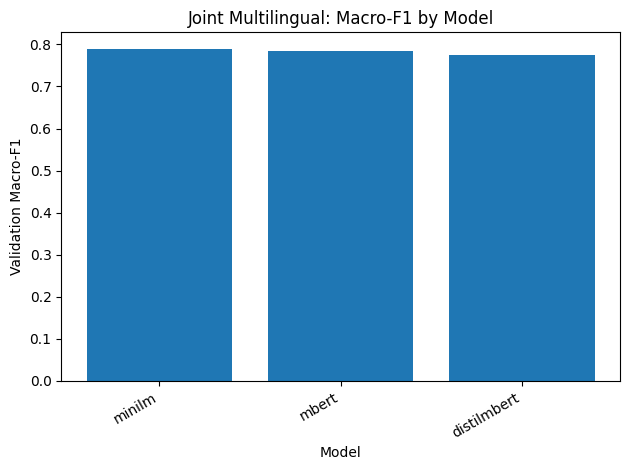

In [21]:
tmp = results_df[["model_key", "eval_f1_macro"]].copy().sort_values("eval_f1_macro", ascending=False)
plot_bar_from_df(
    tmp, "model_key", "eval_f1_macro",
    title="Joint Multilingual: Macro-F1 by Model",
    xlabel="Model", ylabel="Validation Macro-F1", rotate=30
)


#Plot: Monolingual per-language Macro-F1 (if monolingual ran)

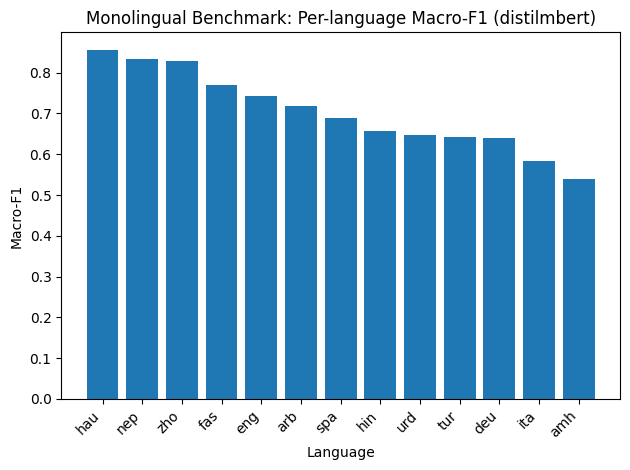

In [22]:
if mono_df is not None and len(mono_df) > 0:
    mono_plot = mono_df.sort_values("eval_f1_macro", ascending=False)
    plot_bar_from_df(
        mono_plot, "lang", "eval_f1_macro",
        title=f"Monolingual Benchmark: Per-language Macro-F1 ({MONO_MODEL})",
        xlabel="Language", ylabel="Macro-F1", rotate=45
    )


#Plot: Weakest 5 languages (monolingual)

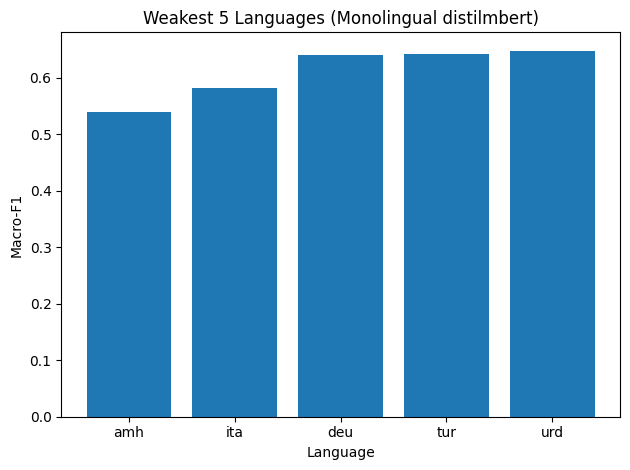

In [23]:
if mono_df is not None and len(mono_df) > 0:
    weak5 = mono_df.sort_values("eval_f1_macro", ascending=True).head(5)
    plot_bar_from_df(
        weak5, "lang", "eval_f1_macro",
        title=f"Weakest 5 Languages (Monolingual {MONO_MODEL})",
        xlabel="Language", ylabel="Macro-F1", rotate=0
    )


#Plot: Few-shot gain vs zero-shot (if transfer ran)

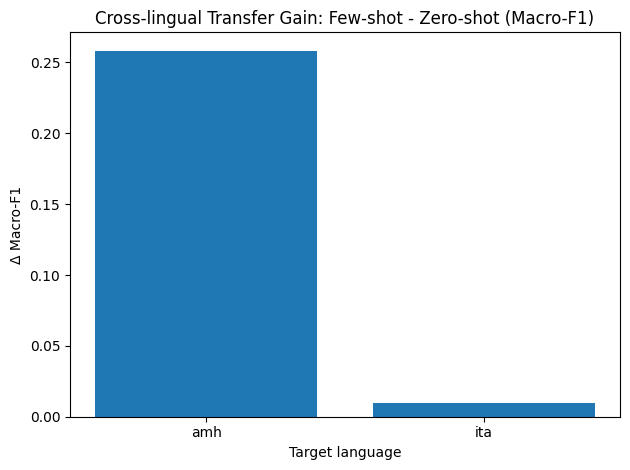

In [24]:
if zero_df is not None and fewshot_df is not None:
    z = zero_df[["target_lang","f1_macro"]].rename(columns={"target_lang":"lang","f1_macro":"zero"})
    f = fewshot_df[["target_lang","f1_macro"]].rename(columns={"target_lang":"lang","f1_macro":"few"})
    m = z.merge(f, on="lang")
    m["delta"] = m["few"] - m["zero"]
    m = m.sort_values("delta", ascending=False)

    plot_bar_from_df(
        m, "lang", "delta",
        title="Cross-lingual Transfer Gain: Few-shot - Zero-shot (Macro-F1)",
        xlabel="Target language", ylabel="Δ Macro-F1", rotate=0
    )


#Plot: Ensemble per-language Macro-F1

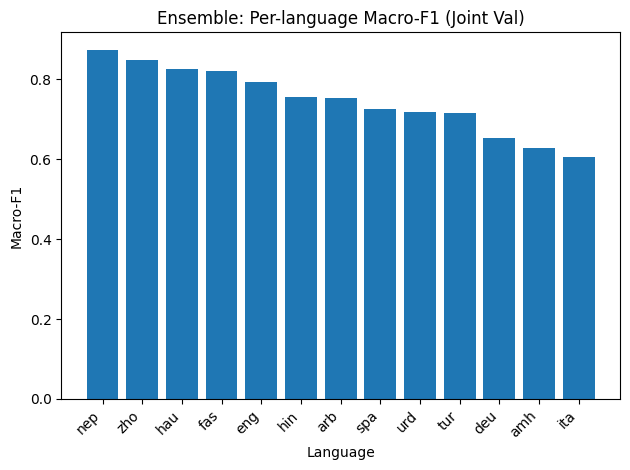

In [25]:
plot_bar_from_df(
    per_lang_metrics.sort_values("f1_macro", ascending=False),
    "lang", "f1_macro",
    title="Ensemble: Per-language Macro-F1 (Joint Val)",
    xlabel="Language", ylabel="Macro-F1", rotate=45
)


#Confusion matrix: Best single joint model

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

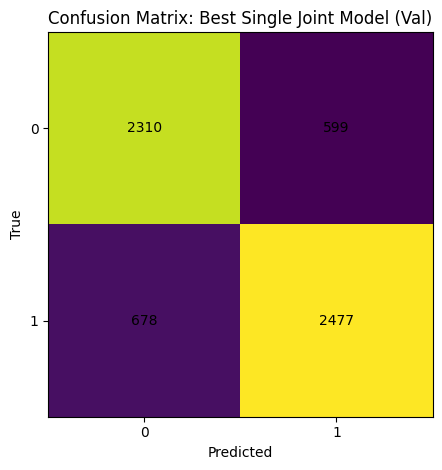

In [26]:
# Predict on joint val with best_trainer
val_ds = Dataset.from_pandas(joint_val_df[["id","lang","text","polarization"]])
tok = best_trainer.tokenizer
val_ds = val_ds.map(lambda x: tok(x["text"], truncation=True, max_length=MAX_LEN), batched=True)
val_ds = val_ds.rename_column("polarization","labels")
val_ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

logits = best_trainer.predict(val_ds).predictions
y_pred = np.argmax(logits, axis=-1)
y_true = joint_val_df["polarization"].astype(int).to_numpy()

plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix: Best Single Joint Model (Val)")


#Confusion matrix: Ensemble

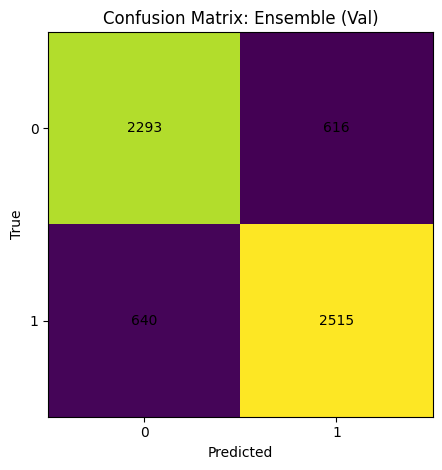

In [27]:
plot_confusion_matrix(ens_y_true, ens_y_pred, title="Confusion Matrix: Ensemble (Val)")
